In [1]:
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
import time

# Clone the dataset repository
!git clone https://github.com/experiencor/raccoon_dataset

2024-07-27 15:39:53.962392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 15:39:53.962532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 15:39:54.108310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 646, done.
remote: Counting objects: 100% (646/646), done.
remote: Compressing objects: 100% (232/232), done.
remote: Total 646 (delta 413), reused 643 (delta 412), pack-reused 0
Receiving objects: 100% (646/646), 48.00 MiB | 46.77 MiB/s, done.
Resolving deltas: 100% (413/413), done.


In [2]:
def load_raccoon_dataset(path):
    images = []
    boxes = []
    labels = []

    for filename in os.listdir(os.path.join(path, 'annotations')):
        if not filename.endswith('.xml'):
            continue
        tree = ET.parse(os.path.join(path, 'annotations', filename))
        root = tree.getroot()
        
        for elem in root.findall('object'):
            name = elem.find('name').text
            bbox = elem.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            
            img_path = os.path.join(path, 'images', root.find('filename').text)
            image = cv2.imread(img_path)
            image = cv2.resize(image, (224, 224))

            images.append(image)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Label for raccoon

    return np.array(images), np.array(boxes), np.array(labels)

dataset_path = 'raccoon_dataset'
X_raccoon, boxes_raccoon, y_raccoon = load_raccoon_dataset(dataset_path)

# Convert labels to categorical
y_raccoon = tf.keras.utils.to_categorical(y_raccoon, num_classes=2)

In [12]:
# X_raccoon
# boxes_raccoon
# y_raccoon

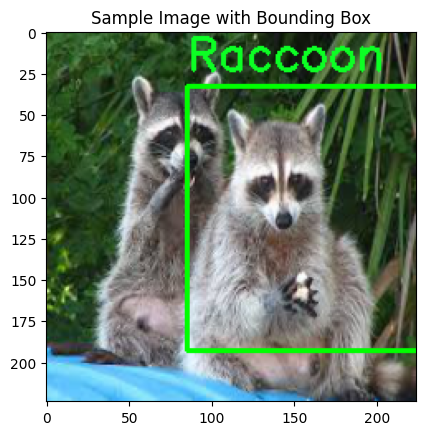

In [14]:
# نمایش یک تصویر نمونه
sample_image = X_raccoon[45]
sample_box = boxes_raccoon[45]

def draw_bounding_box(image, box, label):
    xmin, ymin, xmax, ymax = box
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

image_copy = sample_image.copy()
draw_bounding_box(image_copy, sample_box, 'Raccoon')

plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
plt.title('Sample Image with Bounding Box')
plt.show()

# RCNN

In [4]:
def build_rcnn_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = Flatten()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    output = Dense(2, activation='softmax')(x)  # 2 classes in raccoon dataset

    model = Model(inputs=base_model.input, outputs=output)
    return model

rcnn_model = build_rcnn_model()
rcnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train R-CNN model
start_time = time.time()
rcnn_history_raccoon = rcnn_model.fit(X_raccoon, y_raccoon, epochs=10, batch_size=32, validation_split=0.2)
rcnn_time = time.time() - start_time

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


2024-07-27 15:40:16.293644: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-07-27 15:40:16.293703: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-07-27 15:40:16.293717: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-07-27 15:40:16.293730: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-07-27 15:40:16.293750: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-07-27 15:40:16.293761: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-07-27 15:40:16.293772: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-07-27 15:40:16.293782: E external/local_xla/xla/se

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.7574 - loss: 7.2192

2024-07-27 15:40:52.952919: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100352: 5.04893, expected 4.24247
2024-07-27 15:40:52.952975: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100353: 6.99988, expected 6.19341
2024-07-27 15:40:52.952990: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100354: 6.949, expected 6.14253
2024-07-27 15:40:52.953004: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100355: 6.3455, expected 5.53903
2024-07-27 15:40:52.953022: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100356: 6.4062, expected 5.59973
2024-07-27 15:40:52.953034: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100357: 6.93991, expected 6.13344
2024-07-27 15:40:52.953046: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100358: 5.95738, expected 5.15092
2024-07-27 15:40:52.9530

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7815 - loss: 6.5034   

W0000 00:00:1722094870.109526     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-07-27 15:41:10.593822: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.37359, expected 2.7841
2024-07-27 15:41:10.593875: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.43935, expected 3.84986
2024-07-27 15:41:10.593898: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.60416, expected 4.01467
2024-07-27 15:41:10.593911: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.68174, expected 4.09225
2024-07-27 15:41:10.593924: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.80871, expected 4.21922
2024-07-27 15:41:10.593938: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.51692, expected 3.92744
2024-07-27 15:41:10.593951: E external/local_xla/xla/service/gpu/b

6/6 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step - accuracy: 0.7986 - loss: 5.9920 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 1.0000 - loss: 0.